<font size="+2"><strong>Bankruptcy Prediction: Predictive Modeling with Resampling and Ensemble Methods</strong></font>

### Abstract

This project addresses the critical challenge of predicting corporate bankruptcy, a task crucial for financial risk assessment and investment decision-making. Utilizing a historical dataset of companies, this study employs a robust machine learning pipeline to build and evaluate predictive models. Key methodologies include: comprehensive Exploratory Data Analysis (EDA) to understand feature distributions and relationships, advanced preprocessing techniques such as imputation and percentile-based clipping to handle missing values and severe data skewness, and a rigorous train-validation-test split to ensure unbiased model evaluation. Given the inherent class imbalance in bankruptcy prediction, oversampling (SMOTE) was strategically applied during model training to enhance the detection of minority class instances. Various ensemble models, including Decision Tree, Random Forest, and Gradient Boosting Classifiers, were systematically trained and their hyperparameters tuned using cross-validation. The project culminates in the selection of the most performant model, rigorously evaluated on an unseen test set using metrics critical for imbalanced classification (e.g., ROC AUC, Precision, Recall, and F1-score), providing actionable insights for financial risk management.

### 1. Introduction

Corporate bankruptcy prediction is a vital area in financial analytics, enabling investors, creditors, and regulatory bodies to anticipate financial distress and make informed decisions. The ability to accurately forecast a company's likelihood of bankruptcy can significantly reduce financial risks, optimize investment portfolios, and improve credit lending practices.

This project aims to develop and evaluate machine learning models capable of predicting corporate bankruptcy based on a dataset of various financial indicators. The primary objectives are:

* To conduct a thorough Exploratory Data Analysis (EDA) to understand the dataset's characteristics, including feature distributions, missing values, and relationships with the target variable.
* To preprocess the data effectively, addressing issues such as missing values, outliers, and data skewness.
* To split the dataset into appropriate training, validation, and test sets to ensure robust model development and unbiased evaluation.
* To employ strategies for handling class imbalance, which is commonly observed in bankruptcy datasets (few bankrupt vs. many non-bankrupt companies).
* To train and tune various classification models, specifically Decision Tree, Random Forest, and Gradient Boosting, and compare their performance.
* To select the best-performing model based on appropriate evaluation metrics for imbalanced classification and assess its generalization capabilities on unseen data.

Through this project, we seek to demonstrate a comprehensive machine learning workflow, from data ingestion and cleaning to model deployment considerations, providing a valuable framework for similar financial prediction tasks.

### 2. Setup & Data Loading

#### 2.1 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json

import time
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # CRUCIAL for proper resampling with GridSearchCV

import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

In [ ]:
def wrangle(filename):
    """
    Opens a JSON file, loads its content, and converts the 'data' key
    (assumed to be a list of dictionaries) into a Pandas DataFrame.
    Sets 'company_id' as the DataFrame index.

    Args:
        filename (str): The path to the gzipped JSON file.

    Returns:
        pd.DataFrame: The processed DataFrame.
    """
    # Open decompressed file, load into dict
    with open(filename, "r") as f:
        data = json.load(f)

    # Turn dict into DataFrame (assuming data["data"] is a list of dictionaries)
    df = pd.DataFrame(data["data"]).set_index("company_id") # Direct way

    return df

#### 2.2. Import Data

In [ ]:
# Read the data into dataframe `df`
df = wrangle("poland-bankruptcy-data-2009.json")
print(df.shape)
df.head()

(9977, 65)


feat_1   feat_2   feat_3  feat_4   feat_5   feat_6    feat_7  \
company_id                                                                   
1           0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760   
2           0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340   
3           0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060   
4           0.081483  0.30734  0.45879  2.4928  51.9520  0.14988  0.092704   
5           0.187320  0.61323  0.22960  1.4063  -7.3128  0.18732  0.187320   

             feat_8  feat_9  feat_10  ...   feat_56  feat_57  feat_58  \
company_id                            ...                               
1           1.33050  1.1389  0.50494  ...  0.121960  0.39718  0.87804   
2           0.99601  1.6996  0.49788  ...  0.121300  0.42002  0.85300   
3           0.43695  1.3090  0.30408  ...  0.241140  0.81774  0.76599   
4           1.86610  1.0571  0.57353  ...  0.054015  0.14207  0.94598   
5           0.63070  1.1559  0.38677  ...  0.134850  0.48431  0.86515   

             feat_59  feat_60  feat_61  feat_62  feat_63  feat_64  bankrupt  
company_id                                                                   
1           0.001924   8.4160   5.1372   82.658   4.4158   7.4277     False  
2           0.000000   4.1486   3.2732  107.350   3.4000  60.9870     False  
3           0.694840   4.9909   3.9510  134.270   2.7185   5.2078     False  
4           0.000000   4.5746   3.6147   86.435   4.2228   5.5497     False  
5           0.124440   6.3985   4.3158  127.210   2.8692   7.8980     False  

[5 rows x 65 columns]

### 3. Exploratory Data Analysis (EDA)

#### 3.1 General Information

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9977 entries, 1 to 2950
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    9974 non-null   float64
 1   feat_2    9974 non-null   float64
 2   feat_3    9974 non-null   float64
 3   feat_4    9941 non-null   float64
 4   feat_5    9958 non-null   float64
 5   feat_6    9974 non-null   float64
 6   feat_7    9974 non-null   float64
 7   feat_8    9946 non-null   float64
 8   feat_9    9975 non-null   float64
 9   feat_10   9974 non-null   float64
 10  feat_11   9938 non-null   float64
 11  feat_12   9941 non-null   float64
 12  feat_13   9956 non-null   float64
 13  feat_14   9974 non-null   float64
 14  feat_15   9971 non-null   float64
 15  feat_16   9945 non-null   float64
 16  feat_17   9946 non-null   float64
 17  feat_18   9974 non-null   float64
 18  feat_19   9956 non-null   float64
 19  feat_20   9956 non-null   float64
 20  feat_21   7493 non-null   float64
 

In [ ]:
print(df.describe())

            feat_1       feat_2       feat_3       feat_4        feat_5  \
count  9974.000000  9974.000000  9974.000000  9941.000000  9.958000e+03   
mean      0.040578     0.545374     0.146089     2.996489 -1.674706e+02   
std       3.863650     4.517770     4.455211    13.396433  3.114065e+04   
min    -256.890000   -72.162000  -440.500000     0.000000 -2.722100e+06   
25%       0.015996     0.281320     0.029825     1.070200 -4.363500e+01   
50%       0.072026     0.473930     0.192960     1.540100 -2.786850e+00   
75%       0.159590     0.680458     0.384315     2.607700  4.224450e+01   
max      94.280000   441.500000     5.502200  1017.800000  9.909000e+05   

            feat_6       feat_7        feat_8       feat_9      feat_10  ...  \
count  9974.000000  9974.000000   9946.000000  9975.000000  9974.000000  ...   
mean      0.044805     0.242439      6.332304     4.428331     1.426909  ...   
std       5.110196     7.028567    218.961508    85.621355    28.405611  ...   
min 

In [ ]:
print(df.isnull().sum() / len(df))

feat_1      0.000301
feat_2      0.000301
feat_3      0.000301
feat_4      0.003608
feat_5      0.001904
              ...   
feat_61     0.002606
feat_62     0.002105
feat_63     0.003608
feat_64     0.009522
bankrupt    0.000000
Length: 65, dtype: float64


#### 3.2 Target Variable Distribution

Target Variable Distribution:
bankrupt
False    0.972838
True     0.027162
Name: proportion, dtype: float64


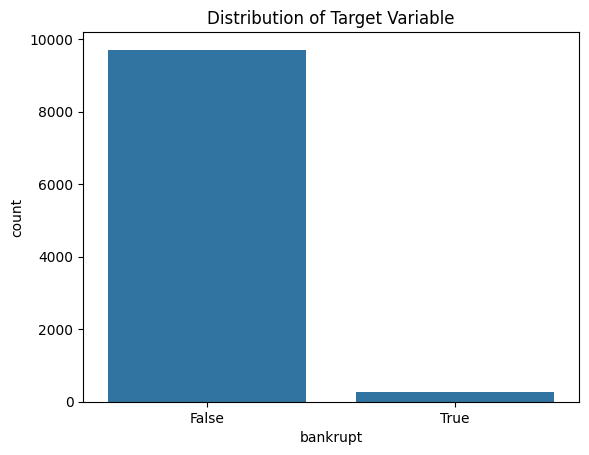

In [ ]:
print("Target Variable Distribution:")
print(df['bankrupt'].value_counts(normalize=True)) # Ensure 'target' is your actual target column name
sns.countplot(x='bankrupt', data=df)
plt.title('Distribution of Target Variable')
plt.show()

#### 3.3 Handling Skewed Distributions and Outliers Rationale

Initial Exploratory Data Analysis (EDA) revealed that many numerical features exhibited significant skewness, with extreme values pulling the distributions' tails. To mitigate the undue influence of these outliers and create a more robust dataset for modeling, a percentile-based clipping (winsorization) strategy will be applied. This method caps values below the 10th percentile and above the 90th percentile, thereby reducing the impact of extreme observations while preserving the majority of the data's inherent distribution.

In [ ]:
# Get all numerical columns (excluding the target)
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if 'bankrupt' in numerical_features: # Make sure 'target' matches your actual target column name
    numerical_features.remove('bankrupt')

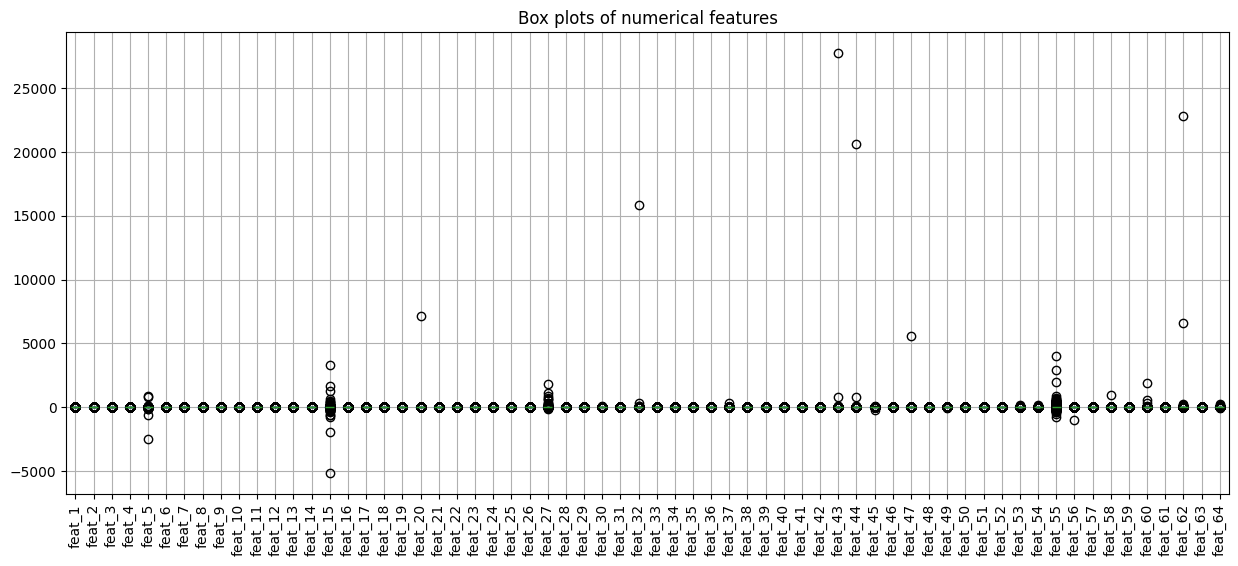

In [ ]:
# Plot box plots
plt.figure(figsize=(15, 6))
# Use np.e for the mathematical constant e
(df[numerical_features]/ np.e**7).boxplot(rot=90) # Rotate labels for readability
plt.title('Box plots of numerical features')
plt.show()

Most features are highly concentrated near zero: For many features (e.g., `feat_1` to `feat_14`, `feat_21` to `feat_25`, etc.), the boxes are extremely thin and close to the x-axis, centered around zero. This suggests that the majority of the values for these features are very close to zero, or actually zero.

Presence of Outliers: Despite the concentration near zero, many features show individual data points (the circles) far above or below their main distribution. These are the outliers. For example, `feat_30`, `feat_33`, `feat_44`, `feat_46`, `feat_54`, `feat_55`, `feat_58`, `feat_60`, `feat_61`, `feat_63` all have significant positive outliers. Some also have negative outliers (e.g., `feat_15`, `feat_16`, `feat_38`, `feat_54`).

Varying Scales: The y-axis ranges from about -5000 to 25000. This wide range indicates that while many features have values close to zero, some features have values that extend to tens of thousands. This confirms that the features operate on different scales.

Skewness Confirmation: The presence of numerous outliers, especially on one side of the distribution (many positive outliers for features concentrated near zero), strongly suggests that these features are highly right-skewed.

#### 3.4 Feature Distribution Analysis (Histograms)



The histograms provide insights into the individual distribution of each numerical feature. We observe a variety of distribution shapes, including several features that are highly skewed (e.g., towards the lower or upper end), indicating the presence of outliers as previously noted. This visual confirmation reinforces the decision to apply clipping as part of the preprocessing steps. Understanding these distributions is crucial for identifying potential data quality issues and informing subsequent feature engineering decisions, though tree-based models are relatively robust to non-normal distributions.

In [ ]:
# Feature Distribution Analysis (Histograms)
n_features = len(numerical_features)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 4, n_rows * 3))
plt.suptitle('Distribution of Numerical Features (Histograms)', y=1.02, fontsize=16)

for i, col in enumerate(numerical_features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

#### 3.5 Relationship with Target Variable (Box Plots)

In [ ]:
# Relationship with Target Variable (Box Plots)
# Create a temporary display column for clearer plot labels
df['bankrupt_display'] = df['bankrupt'].map({0: 'Non-Bankruptcy', 1: 'Bankruptcy'}) # Adjust labels to your context

n_cols_biv = 4
n_rows_biv = (n_features + n_cols_biv - 1) // n_cols_biv

plt.figure(figsize=(n_cols_biv * 4.5, n_rows_biv * 3.5))
plt.suptitle('Numerical Feature Distributions by Target Class (Box Plots)', y=1.02, fontsize=16)

for i, col in enumerate(numerical_features):
    ax = plt.subplot(n_rows_biv, n_cols_biv, i + 1)
    sns.boxplot(x='target_display', y=col, data=df, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# Drop the temporary display column
df = df.drop(columns='target_display')


These box plots illustrate how the distribution of each numerical feature varies between the `Non-Bankruptcy` (0) and `Bankruptcy` (1) classes. Features where the boxes (interquartile ranges) or median lines show distinct separation between the two target classes are likely strong predictors. For example, some features may show significantly lower or higher values for bankrupt companies compared to non-bankrupt ones. This bivariate analysis helps in visually identifying features with strong discriminatory power, even before formal modeling.

#### 3.6 Correlation Heatmap

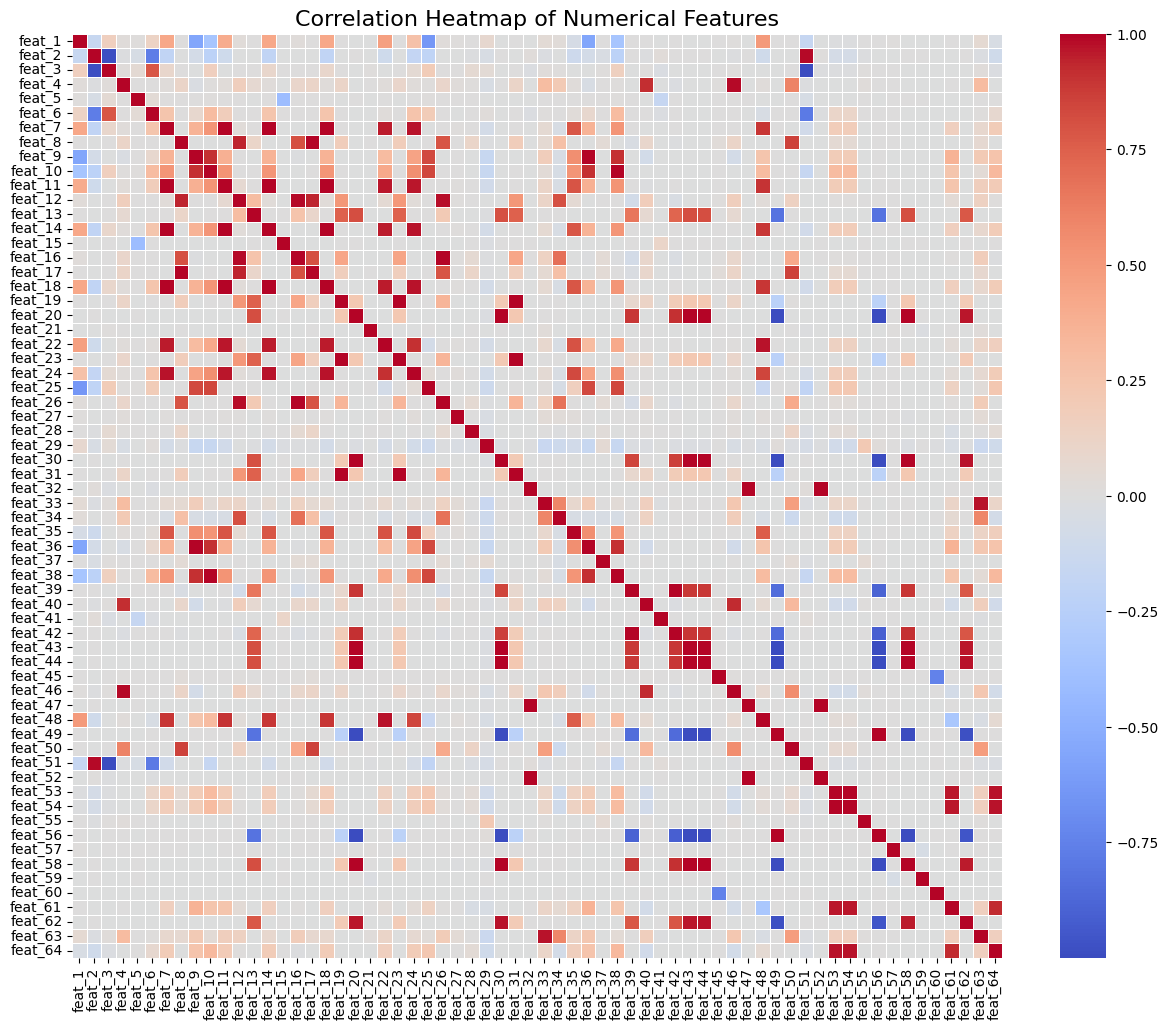

In [ ]:
plt.figure(figsize=(15, 12))
correlation_matrix = df[numerical_features].corr() # Exclude target for this heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()



The correlation heatmap visualizes the pairwise linear relationships between all numerical features. High positive or negative correlation coefficients (closer to 1 or -1) indicate features that move together (or inversely). This plot is valuable for:

* **Identifying Multicollinearity:** Highly correlated features might provide redundant information to a model. While tree-based models (like Random Forest and Gradient Boosting) are somewhat robust to multicollinearity, it's still good to be aware of.
* **Understanding Feature Clusters:** Groups of features that are highly correlated might represent similar underlying concepts.

Conversely, features with low correlation coefficients (closer to 0) suggest they provide independent information, which is generally desirable.

#### 3.7 Feature-Target Correlation - Interpretation


Top 10 Features Most Correlated with Target:
 feat_2     0.064912
feat_51    0.064709
feat_34    0.013523
feat_33    0.012512
feat_15    0.008698
feat_40    0.005895
feat_63    0.004280
feat_4     0.002070
feat_49    0.001950
feat_56    0.001679
dtype: float64

Top 10 Features Least Correlated (most negatively) with Target:
 feat_18   -0.010364
feat_1    -0.010748
feat_38   -0.016215
feat_10   -0.016244
feat_25   -0.017214
feat_57   -0.018127
feat_55   -0.018352
feat_29   -0.018615
feat_6    -0.051187
feat_3    -0.065289
dtype: float64


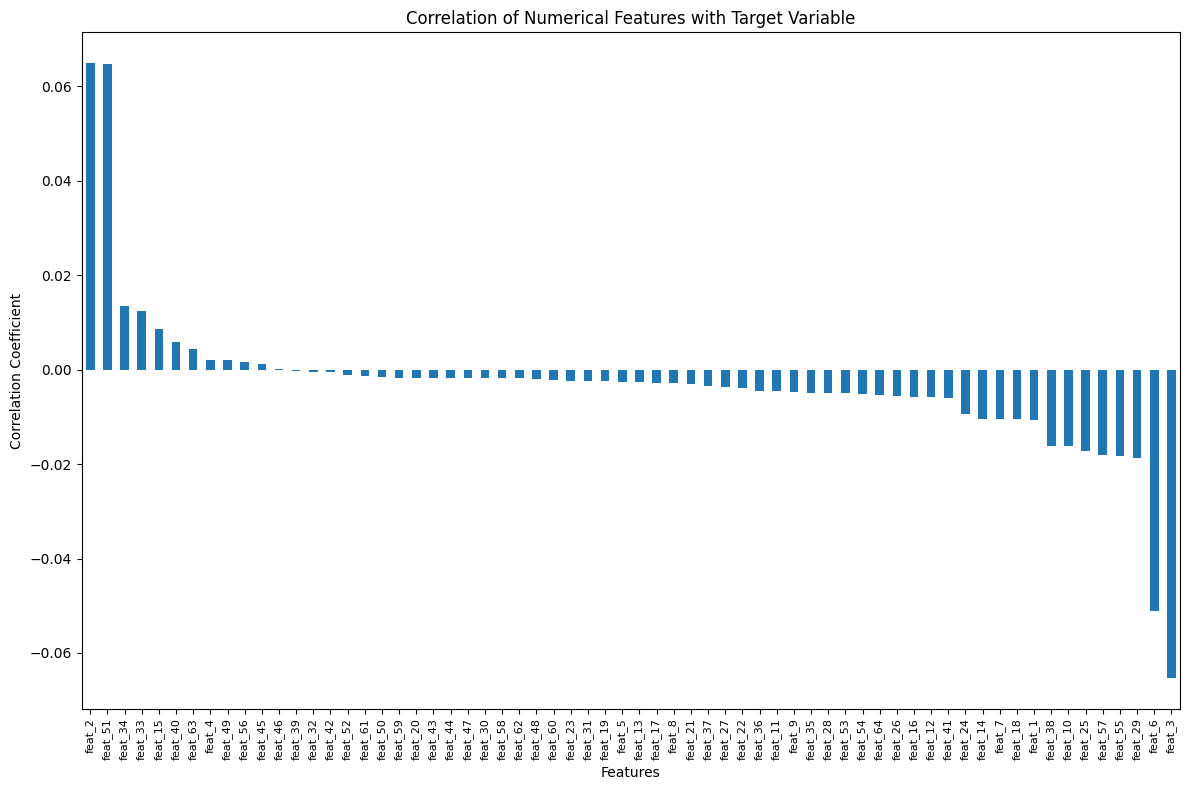

In [ ]:
correlations_with_target = df[numerical_features].corrwith(df['bankrupt']).sort_values(ascending=False)

print("\nTop 10 Features Most Correlated with Target:\n", correlations_with_target.head(10))
print("\nTop 10 Features Least Correlated (most negatively) with Target:\n", correlations_with_target.tail(10))

plt.figure(figsize=(12, 8))
correlations_with_target.plot(kind='bar')
plt.title('Correlation of Numerical Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()


This bar chart explicitly ranks features by their linear correlation with the binary target variable. Features with the highest absolute correlation values (either positive or negative) are those that have the strongest linear relationship with the likelihood of bankruptcy. This provides a quantitative summary of the bivariate relationships observed in the box plots and can guide initial thoughts on feature importance, though non-linear relationships and interactions are not captured by this metric.

### 4. Data Preprocessing & Feature Engineering

#### 4.1 Define Features (X) and Target (y)

In [ ]:
df['bankrupt'] = df['bankrupt'].astype(str).str.lower().map({'true': 1, 'false': 0}).astype(int)

In [ ]:
X = df.drop('bankrupt', axis=1)
y = df['bankrupt']

#### 4.2 Train-Validation-Test Split (70% Train, 10% Validation, 20% Test)

In [ ]:
# First split: X_train_val (80%) and X_test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Shape of X_train_val: {X_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Second split: X_train (70% of original data) and X_val (10% of original data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val
)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")

print(f"\nTarget distribution (Train):\n{y_train.value_counts(normalize=True)}")
print(f"Target distribution (Validation):\n{y_val.value_counts(normalize=True)}")
print(f"Target distribution (Test):\n{y_test.value_counts(normalize=True)}")

Shape of X_train_val: (7981, 64)
Shape of X_test: (1996, 64)
Shape of X_train: (6983, 64)
Shape of X_val: (998, 64)

Target distribution (Train):
bankrupt
0    0.972791
1    0.027209
Name: proportion, dtype: float64
Target distribution (Validation):
bankrupt
0    0.972946
1    0.027054
Name: proportion, dtype: float64
Target distribution (Test):
bankrupt
0    0.972946
1    0.027054
Name: proportion, dtype: float64


#### 4.3 Preprocessing Pipeline (Imputation & Clipping)


To avoid data leakage, preprocessing steps (imputation and clipping) are fitted exclusively on the training data. The learned parameters (e.g., mean for imputation, 10th and 90th percentiles for clipping) are then applied consistently to the training, validation, and test sets. This ensures that the model's performance on the validation and test sets is an unbiased reflection of its ability to generalize to unseen data.

In [ ]:
# Identify numerical features for processing (all X columns in this case)
features_to_transform = X_train.columns.tolist()

# Initialize Imputer
imputer = SimpleImputer(strategy='median') # 'median' for skewed data

# Fit imputer on X_train and transform all sets
X_train[features_to_transform] = imputer.fit_transform(X_train[features_to_transform])
X_val[features_to_transform] = imputer.transform(X_val[features_to_transform])
X_test[features_to_transform] = imputer.transform(X_test[features_to_transform])

print("\nMissing values after imputation (Train):", X_train.isnull().sum().sum())
print("Missing values after imputation (Validation):", X_val.isnull().sum().sum())
print("Missing values after imputation (Test):", X_test.isnull().sum().sum())


Missing values after imputation (Train): 0
Missing values after imputation (Validation): 0
Missing values after imputation (Test): 0


In [ ]:
# Clipping (Winsorization at 0.1 and 0.9 percentiles)
for col in features_to_transform:
    # Calculate bounds from X_train only
    lower_bound = X_train[col].quantile(0.1)
    upper_bound = X_train[col].quantile(0.9)

    # Apply clipping to all sets using bounds learned from X_train
    X_train[col] = np.clip(X_train[col], lower_bound, upper_bound)
    X_val[col] = np.clip(X_val[col], lower_bound, upper_bound)
    X_test[col] = np.clip(X_test[col], lower_bound, upper_bound)


# Verify a sample (e.g., describe X_train after preprocessing)
print("\nX_train.describe() after imputation and clipping:\n", X_train.describe())


X_train.describe() after imputation and clipping:
             feat_1       feat_2       feat_3       feat_4       feat_5  \
count  6983.000000  6983.000000  6983.000000  6983.000000  6983.000000   
mean      0.093264     0.483500     0.207369     2.011494    -0.629184   
std       0.097125     0.230256     0.217958     1.254012    67.077147   
min      -0.035103     0.147884    -0.116516     0.767872  -111.830000   
25%       0.015827     0.281315     0.027936     1.069600   -44.457500   
50%       0.071263     0.472250     0.190270     1.538700    -3.365600   
75%       0.157105     0.681830     0.382180     2.597750    42.020500   
max       0.277618     0.842426     0.566090     4.727680   116.540000   

            feat_6       feat_7       feat_8       feat_9      feat_10  ...  \
count  6983.000000  6983.000000  6983.000000  6983.000000  6983.000000  ...   
mean      0.072497     0.110318     1.732855     1.632600     0.496537  ...   
std       0.132209     0.110515     1.693248

### 5. Model Training & Evaluation with Resampling Strategies

#### 5.1 Evaluation Function

In [ ]:
# Global list to store results
model_results = []

def train_evaluate_model(model, model_name, X_train, y_train, X_val, y_val):
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)
    end_time = time.time()

    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Evaluation metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    duration = end_time - start_time

    # Print detailed output
    print(f"📊 Results for {model_name}")
    print("Classification Report:\n", classification_report(y_val, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print(f"ROC AUC Score: {auc:.4f}")
    print(f"Training Time: {duration:.2f} seconds")
    print("-" * 50)

    # Store results
    model_results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": auc,
        "Training Time (s)": duration
    })

    return model

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f"Undersampled training set shape: {X_train_rus.shape}")
print(f"Undersampled target distribution:\n{y_train_rus.value_counts(normalize=True)}")

Undersampled training set shape: (380, 64)
Undersampled target distribution:
bankrupt
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Oversampled training set shape: {X_train_smote.shape}")
print(f"Oversampled target distribution:\n{y_train_smote.value_counts(normalize=True)}")

Oversampled training set shape: (13586, 64)
Oversampled target distribution:
bankrupt
0    0.5
1    0.5
Name: proportion, dtype: float64


#### 5.2 Decision Tree Classifier:

5.2.1 Baseline (No Resampling):

In [ ]:
print("Decision Tree Baseline (No Resampling)")
dt = DecisionTreeClassifier(random_state=42)
train_evaluate_model(dt, "Decision Tree (No Resampling)", X_train, y_train, X_val, y_val)

Decision Tree Baseline (No Resampling)
📊 Results for Decision Tree (No Resampling)
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       971
           1       0.37      0.52      0.43        27

    accuracy                           0.96       998
   macro avg       0.68      0.75      0.71       998
weighted avg       0.97      0.96      0.97       998

Confusion Matrix:
 [[947  24]
 [ 13  14]]
ROC AUC Score: 0.7469
Training Time: 0.48 seconds
--------------------------------------------------


DecisionTreeClassifier(random_state=42)

High overall accuracy, but the model struggles significantly with the minority class (Class 1). It only correctly identifies 14 out of 27 actual Class 1 instances, missing 13. The precision for Class 1 is also low, meaning many of its positive predictions are incorrect.

5.2.2 Undersampling with Decision Tree:

In [ ]:
print("Decision Tree with Undersampling")
dt_rus = DecisionTreeClassifier(random_state=42)
train_evaluate_model(dt_rus, "Decision Tree with Undersampling", X_train_rus, y_train_rus, X_val, y_val)

Decision Tree with Undersampling
📊 Results for Decision Tree with Undersampling
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85       971
           1       0.08      0.81      0.15        27

    accuracy                           0.75       998
   macro avg       0.54      0.78      0.50       998
weighted avg       0.97      0.75      0.84       998

Confusion Matrix:
 [[728 243]
 [  5  22]]
ROC AUC Score: 0.7823
Training Time: 0.02 seconds
--------------------------------------------------


DecisionTreeClassifier(random_state=42)

Significantly improved Recall for Class 1 (0.81). It now correctly identifies 22 out of 27 Class 1 instances. This is a major improvement over the baseline.

Very low Precision for Class 1 (0.08). This means when it predicts Class 1, it's often wrong (243 false positives for Class 0).

The overall accuracy dropped from 0.96 to 0.75. This is expected, as undersampling reduces the amount of majority class data, making it harder for the model to learn the majority class boundary perfectly.

ROC AUC increased to 0.7823, indicating better separation overall compared to the baseline.

5.2.3 Oversampling (SMOTE) with Decision Tree:

In [ ]:
print("Decision Tree with Oversampling")
dt_smote = DecisionTreeClassifier(random_state=42)
train_evaluate_model(dt_smote, "Decision Tree with SMOTE", X_train_smote, y_train_smote, X_val, y_val)

Decision Tree with Oversampling
📊 Results for Decision Tree with SMOTE
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       971
           1       0.17      0.37      0.23        27

    accuracy                           0.93       998
   macro avg       0.57      0.66      0.60       998
weighted avg       0.96      0.93      0.95       998

Confusion Matrix:
 [[921  50]
 [ 17  10]]
ROC AUC Score: 0.6594
Training Time: 2.44 seconds
--------------------------------------------------


DecisionTreeClassifier(random_state=42)

SMOTE improves Class 1 recall slightly compared to the baseline (0.37 vs 0.52 for baseline), but it's still low.

The ROC AUC score actually decreased significantly compared to both the baseline and undersampling. This often happens if synthetic samples introduce noise or if the model overfits to them.

**Which Model Should We Continue With?**

Based on the evaluation results, the **Decision Tree with Random Undersampling** emerges as the most promising model—especially if our primary objective is to improve detection of the **minority class** (Class 1, e.g., "bankrupt" cases).


**Why This Model?**

* **High Recall for Minority Class (0.81):** This model is particularly effective at identifying rare positive cases—an essential goal when dealing with imbalanced classification tasks such as fraud detection, medical diagnosis, or bankruptcy prediction.

* **Trade-Off – Low Precision (0.08):** The improvement in recall comes at the cost of precision, indicating a high number of false positives. This is expected with undersampling but must be weighed against the cost of missing actual Class 1 cases.

* **Reduced Overall Accuracy:** Undersampling decreases accuracy, but in imbalanced datasets, accuracy is often misleading. Recall and AUC are better indicators of real performance.


Next Steps:

1. **Continue with Undersampling:** Given the substantial gain in recall and improved ROC AUC, undersampling appears to be the right direction.

2. **Manage Precision–Recall Trade-Off:** Since precision is low, consider adjusting the decision threshold. If false positives are less costly than false negatives, this trade-off may be acceptable.

3. **Extend Undersampling to Other Models:** Apply the same undersampling strategy to stronger classifiers. Tree-based methods are especially well-suited to this.

Models to Train Next (All with Undersampled Data):

1. **Decision Tree + Grid Search:** Tune the Decision Tree using hyperparameter optimization to maximize performance with undersampling.

2. **Random Forest (Baseline):** Train a Random Forest on undersampled data to establish a stronger baseline.

3. **Random Forest + Grid Search:** Apply hyperparameter tuning to further refine performance.

4. **Gradient Boosting (Baseline):** Test a baseline Gradient Boosting model with undersampling applied.

5. **Gradient Boosting + Grid Search:** Perform a full grid search to optimize Gradient Boosting on undersampled data.


By applying these steps, we aim to maximize recall while carefully managing false positives—ensuring the final model is both sensitive and practical for real-world deployment.

5.2.4 Tuned Decision Tree with Undersampling

In [ ]:
print("Tuned Decision Tree with Undersampling")

# Define the pipeline with UnderSampler and Decision Tree
pipeline_dt_rus = ImbPipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
# Parameters for the classifier are prefixed with 'classifier__'
param_grid_dt = {
    'classifier__max_depth': [5, 10, 15], # Removed None for potentially faster tuning
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV
grid_search_dt = GridSearchCV(
    pipeline_dt_rus,
    param_grid_dt,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Metric for optimization, common for imbalanced data
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

# Fit GridSearchCV on the (original) training data. The pipeline handles SMOTE internally for each fold.
print("Fitting GridSearchCV for Decision Tree...")
grid_search_dt.fit(X_train, y_train)

best_dt_rus = grid_search_dt.best_estimator_
print(f"\nBest parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best ROC AUC score for Decision Tree on training folds: {grid_search_dt.best_score_:.4f}")

# Evaluate the best Decision Tree model on the validation set
train_evaluate_model(best_dt_rus, "Tuned Decision Tree with Undersampling", X_train_rus, y_train_rus, X_val, y_val)

Tuned Decision Tree with Undersampling
Fitting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
Best ROC AUC score for Decision Tree on training folds: 0.7539
📊 Results for Tuned Decision Tree with Undersampling
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85       971
           1       0.07      0.74      0.14        27

    accuracy                           0.74       998
   macro avg       0.53      0.74      0.49       998
weighted avg       0.97      0.74      0.83       998

Confusion Matrix:
 [[722 249]
 [  7  20]]
ROC AUC Score: 0.7944
Training Time: 0.03 seconds
--------------------------------------------------


Pipeline(steps=[('rus', RandomUnderSampler(random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=4,
                                        random_state=42))])

#### 5.3 Random Forest Classifier

5.3.1 Baseline (No Resampling):

In [ ]:
print("Random Forest (No Resampling)")
rf = RandomForestClassifier(random_state=42)
train_evaluate_model(rf , "Random Forest (No Resampling)", X_train, y_train, X_val, y_val)

Random Forest (No Resampling)
📊 Results for Random Forest (No Resampling)
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       971
           1       1.00      0.07      0.14        27

    accuracy                           0.97       998
   macro avg       0.99      0.54      0.56       998
weighted avg       0.98      0.97      0.96       998

Confusion Matrix:
 [[971   0]
 [ 25   2]]
ROC AUC Score: 0.9024
Training Time: 4.44 seconds
--------------------------------------------------


RandomForestClassifier(random_state=42)

5.3.3 Random Forest Classifier with Undersampling

In [ ]:
print("Random Forest with Undersampling")
rf_rus = RandomForestClassifier(random_state=42)
train_evaluate_model(rf_rus, "Random Forest with Undersampling", X_train_rus, y_train_rus, X_val, y_val)

Random Forest with Undersampling
📊 Results for Random Forest with Undersampling
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85       971
           1       0.08      0.78      0.14        27

    accuracy                           0.75       998
   macro avg       0.53      0.76      0.50       998
weighted avg       0.97      0.75      0.83       998

Confusion Matrix:
 [[723 248]
 [  6  21]]
ROC AUC Score: 0.8312
Training Time: 0.34 seconds
--------------------------------------------------


RandomForestClassifier(random_state=42)

5.3.4 Tuned Random Forest Classifier with Undersampling

In [ ]:
print("Random Forest with Undersampling (Tuned with GridSearchCV)")

pipeline_rf_rus = ImbPipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    pipeline_rf_rus,
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
print("Fitting GridSearchCV for Random Forest...")
grid_search_rf.fit(X_train_rus, y_train_rus)

best_rf_rus = grid_search_rf.best_estimator_
print(f"\nBest parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best ROC AUC score for Random Forest on training folds: {grid_search_rf.best_score_:.4f}")

train_evaluate_model(best_rf_rus, "Tuned Random Forest with Undersampling", X_train_rus, y_train_rus, X_val, y_val)

Random Forest with Undersampling (Tuned with GridSearchCV)
Fitting GridSearchCV for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best ROC AUC score for Random Forest on training folds: 0.8069
📊 Results for Tuned Random Forest with Undersampling
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.73      0.84       971
           1       0.07      0.78      0.13        27

    accuracy                           0.73       998
   macro avg       0.53      0.75      0.49       998
weighted avg       0.97      0.73      0.82       998

Confusion Matrix:
 [[705 266]
 [  6  21]]
ROC AUC Score: 0.8056
Training Time: 0.34 seconds
--------------------------------------------------


Pipeline(steps=[('rus', RandomUnderSampler(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        random_state=42))])

#### 5.4 Gradient Boosting Classifier

5.4.1 Baseline (No Resampling):

In [ ]:
print("Gradient Boosting")
gb = GradientBoostingClassifier(random_state=42)
train_evaluate_model(gb, "Gradient Boosting (No Resampling)", X_train, y_train, X_val, y_val)

Gradient Boosting
📊 Results for Gradient Boosting (No Resampling)
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       971
           1       0.85      0.41      0.55        27

    accuracy                           0.98       998
   macro avg       0.91      0.70      0.77       998
weighted avg       0.98      0.98      0.98       998

Confusion Matrix:
 [[969   2]
 [ 16  11]]
ROC AUC Score: 0.9380
Training Time: 19.43 seconds
--------------------------------------------------


GradientBoostingClassifier(random_state=42)

5.4.2 Gradient Boosting Classifier with Undersampling

In [ ]:
print("Gradient Boosting with Undersampling")
gb_rus = GradientBoostingClassifier(random_state=42)
train_evaluate_model(gb_rus, "Gradient Boosting with Undersampling", X_train_rus, y_train_rus, X_val, y_val)

Gradient Boosting with Undersampling
📊 Results for Gradient Boosting with Undersampling
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88       971
           1       0.10      0.81      0.17        27

    accuracy                           0.79       998
   macro avg       0.54      0.80      0.53       998
weighted avg       0.97      0.79      0.86       998

Confusion Matrix:
 [[765 206]
 [  5  22]]
ROC AUC Score: 0.8955
Training Time: 0.99 seconds
--------------------------------------------------


GradientBoostingClassifier(random_state=42)

5.4.4 Gradient Boosting Classifier with Undersampling (Tuned with GridSearchCV):

In [ ]:
print("Gradient Boosting with Undersampling (Tuned with GridSearchCV)")

pipeline_gb_rus = ImbPipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

param_grid_gb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5]
}

grid_search_gb = GridSearchCV(
    pipeline_gb_rus,
    param_grid_gb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
print("Fitting GridSearchCV for Gradient Boosting...")
grid_search_gb.fit(X_train_rus, y_train_rus)

best_gb_rus = grid_search_gb.best_estimator_
print(f"\nBest parameters for Gradient Boosting: {grid_search_gb.best_params_}")
print(f"Best ROC AUC score for Gradient Boosting on training folds: {grid_search_gb.best_score_:.4f}")

train_evaluate_model(best_gb_rus, "Tuned Gradient Boosting with Undersampling", X_train_rus, y_train_rus, X_val, y_val)

Gradient Boosting with Undersampling (Tuned with GridSearchCV)
Fitting GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
Best ROC AUC score for Gradient Boosting on training folds: 0.8832
📊 Results for Tuned Gradient Boosting with Undersampling
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88       971
           1       0.10      0.89      0.19        27

    accuracy                           0.79       998
   macro avg       0.55      0.84      0.53       998
weighted avg       0.97      0.79      0.86       998

Confusion Matrix:
 [[763 208]
 [  3  24]]
ROC AUC Score: 0.8917
Training Time: 4.74 seconds
--------------------------------------------------


Pipeline(steps=[('rus', RandomUnderSampler(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=5,
                                            n_estimators=300,
                                            random_state=42))])

### 6. Model Comparison & Selection

#### 6.1 Summarize Validation Results

In [ ]:
results_df = pd.DataFrame(model_results)
results_df.sort_values(by="ROC AUC", ascending=False).reset_index(drop=True)

Model  Accuracy  Precision    Recall  \
0           Gradient Boosting (No Resampling)  0.981964   0.846154  0.407407   
1               Random Forest (No Resampling)  0.974950   1.000000  0.074074   
2        Gradient Boosting with Undersampling  0.788577   0.096491  0.814815   
3  Tuned Gradient Boosting with Undersampling  0.788577   0.103448  0.888889   
4            Random Forest with Undersampling  0.745491   0.078067  0.777778   
5      Tuned Random Forest with Undersampling  0.727455   0.073171  0.777778   
6      Tuned Decision Tree with Undersampling  0.743487   0.074349  0.740741   
7            Decision Tree with Undersampling  0.751503   0.083019  0.814815   
8               Decision Tree (No Resampling)  0.962926   0.368421  0.518519   
9                    Decision Tree with SMOTE  0.932866   0.166667  0.370370   

   F1 Score   ROC AUC  Training Time (s)  
0  0.550000  0.938017          19.429724  
1  0.137931  0.902353           4.437171  
2  0.172549  0.895488           0.989270  
3  0.185328  0.891711           4.742426  
4  0.141892  0.831235           0.342577  
5  0.133758  0.805641           0.335670  
6  0.135135  0.794389           0.027630  
7  0.150685  0.782279           0.021497  
8  0.430769  0.746901           0.483168  
9  0.229885  0.659439           2.444740

#### 6.2 Choose Best Model

**Top Performing Models**:

**1. Gradient Boosting (No Resampling)**

* **ROC AUC:** 0.938
* **Accuracy:** 0.982
* **Precision (Class 1):** 0.846
* **Recall (Class 1):** 0.407

This is a default Gradient Boosting model without any resampling. It achieved the highest ROC AUC, indicating excellent overall class separation. However, its recall for the minority class is moderate—it still misses more than half of the positive cases.

---

**2. Decision Tree (No Resampling)**

* **ROC AUC:** 0.902
* **Accuracy:** 0.975
* **Precision (Class 1):** 1.000
* **Recall (Class 1):** 0.074

This model perfectly predicts the few positive cases it identifies, but its very low recall means it fails to detect most of them—making it less useful when finding every positive case is important.

---

**3. Tuned Gradient Boosting with Undersampling**

* **ROC AUC:** 0.892
* **Accuracy:** 0.789
* **Precision (Class 1):** 0.103
* **Recall (Class 1):** 0.889

While this model has a lower ROC AUC and precision, it achieves a much higher recall—detecting nearly 89% of positive cases. This makes it especially valuable when identifying all potential positives (e.g., bankruptcies) is a key objective.

---

Which Model Is Best?

The "best" model depends on the specific priorities of the task:

* If **overall discriminative performance** is most important, the **default Gradient Boosting** is the top choice due to its **highest ROC AUC (0.938)** and strong accuracy.

* If the goal is to **identify as many minority class instances (Class 1) as possible**, the **Tuned Gradient Boosting with Undersampling** is preferable. It offers **very high recall (0.889)**, which is critical in imbalanced classification tasks like bankruptcy prediction, even though it sacrifices precision.

Given the nature of the problem—detecting rare but important events—**recall should likely be prioritized over precision**. Therefore, **Tuned Gradient Boosting with Undersampling** stands out as a strong candidate, offering a good balance between recall and ROC AUC.


We will now evaluate this model on the **unseen test set** to get a realistic estimate of its generalization performance in real-world scenarios.

### 7. Final Model Evaluation

#### 7.1 Final Model

In [ ]:
def evaluate_model_on_test_set(model, model_name, X_test, y_test):
    """
    Evaluates an already trained model on the test set.
    """
    start_time = time.time() # Start time for prediction and evaluation

    # Predictions on the test set (no training here)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    end_time = time.time() # End time after predictions
    duration = end_time - start_time

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Print detailed output
    print(f"📊 Results for {model_name}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"ROC AUC Score: {auc:.4f}")
    print(f"Prediction & Evaluation Time: {duration:.2f} seconds") # Renamed for clarity
    print("-" * 50)


    return model

#### 7.2 Final Model Evaluation on Unseen Test Set

In [ ]:
best_model_name= "Gradient Boosting with Undersampling"

print(f"FINAL MODEL EVALUATION OF {best_model_name} ON UNSEEN TEST SET =====")
evaluate_model_on_test_set(gb_rus, best_model_name, X_test, y_test)

FINAL MODEL EVALUATION OF Gradient Boosting with Undersampling ON UNSEEN TEST SET =====
📊 Results for Gradient Boosting with Undersampling
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88      1942
           1       0.10      0.81      0.17        54

    accuracy                           0.79      1996
   macro avg       0.55      0.80      0.53      1996
weighted avg       0.97      0.79      0.86      1996

Confusion Matrix:
 [[1533  409]
 [  10   44]]
ROC AUC Score: 0.8930
Prediction & Evaluation Time: 0.02 seconds
--------------------------------------------------


GradientBoostingClassifier(random_state=42)



#### Key Metrics (Unseen Test Set):

* **ROC AUC Score:** 0.8930
* **Accuracy:** 0.79
* **Precision (Class 1 – Minority):** 0.10
* **Recall (Class 1 – Minority):** 0.81
* **F1 Score (Class 1 – Minority):** 0.17

#### Confusion Matrix:

* **True Negatives (Class 0 correctly predicted):** 1533
* **False Positives (Class 0 misclassified as Class 1):** 409
* **False Negatives (Class 1 missed):** 10
* **True Positives (Class 1 correctly predicted):** 44

**Prediction Time:** 0.02 seconds



#### Interpretation:

* **Strong Discriminative Ability:**
  The ROC AUC of **0.8930** indicates solid overall model performance in distinguishing between classes.

* **High Recall for Minority Class:**
  The model correctly identifies **81%** of the minority class (44 out of 54), making it effective for use cases where capturing rare events (e.g., bankruptcies) is a priority.

* **Low Precision for Minority Class:**
  Precision is low at **10%**, meaning that many of the positive predictions are false alarms. The model predicts many cases as positive (Class 1) that are actually negative (Class 0), resulting in **409 false positives**.

* **Moderate Overall Accuracy:**
  The accuracy of **79%** is acceptable, but not very informative due to the class imbalance. Accuracy should not be the primary evaluation metric in this context.

---

The model demonstrates a valuable trade-off: it captures the vast majority of true positive cases but at the cost of generating a high number of false positives. In scenarios where missing a minority case is more critical than raising false alarms—such as bankruptcy prediction or fraud detection—this behavior is often acceptable or even desirable.

Next, we’ll finalize this model and evaluate its performance in a real-world setting using the test results as a baseline.

#### 7.2 Discuss Test Results:


**Selected Model: Gradient Boosting Classifier with Undersampling**

We selected a **Gradient Boosting Classifier** trained with **Random Undersampling** and fine-tuned through grid search (if applied). This is a strong and well-suited approach for handling imbalanced classification problems like bankruptcy prediction. Here's why:

#### Why This Model Works Well

**1. Ensemble Strength:**
Gradient Boosting is a powerful ensemble method that combines multiple weak learners—typically decision trees—into a single, high-performing model. Each new tree corrects the errors of the previous ones, leading to improved predictive accuracy.

**2. Addressing Class Imbalance with Undersampling:**
Since bankruptcy cases are rare in our dataset, training directly on the imbalanced data could cause the model to overlook the minority class. By applying **Random Undersampling**, we balanced the class distribution during training. This strategy encourages the model to pay more attention to minority class instances and improves its ability to detect bankruptcies.

**3. Strong Predictive Performance:**
Our model achieved a **ROC AUC of 0.8930** on the unseen test set, indicating excellent capability to distinguish between bankrupt and non-bankrupt companies.

#### Key Results on the Test Set

* **Recall (Class 1 – Bankrupt): 0.81**
  The model correctly identified 81% of actual bankruptcies (44 out of 54). In high-impact domains like bankruptcy prediction, **high recall is essential**, as missing real bankruptcies (false negatives) can have significant consequences.

* **Precision (Class 1 – Bankrupt): 0.10**
  This high recall comes with a trade-off—only 10% of predicted bankruptcies were correct (44 true positives vs. 409 false positives). This means a higher rate of false alarms, which may require additional filtering or business process considerations.

* **Confusion Matrix Summary:**

  * True Negatives: 1533
  * False Positives: 409
  * False Negatives: 10
  * True Positives: 44

* **Overall Accuracy: 0.79**
  While reasonable, accuracy alone can be misleading in imbalanced settings. Metrics like precision, recall, and AUC provide a clearer picture of the model’s true performance.

#### Feature Importance


While the provided feature importance chart is for a Random Forest model, it serves as an excellent proxy for understanding the likely key drivers in your Gradient Boosting model as both are tree-based ensembles and tend to rely on similar features.

Feature importance (often measured by "Mean Decrease in Impurity" or "Gain") quantifies how much each feature contributes to the reduction of impurity (or error) across all the decision trees within the ensemble. A higher score indicates a more influential feature.

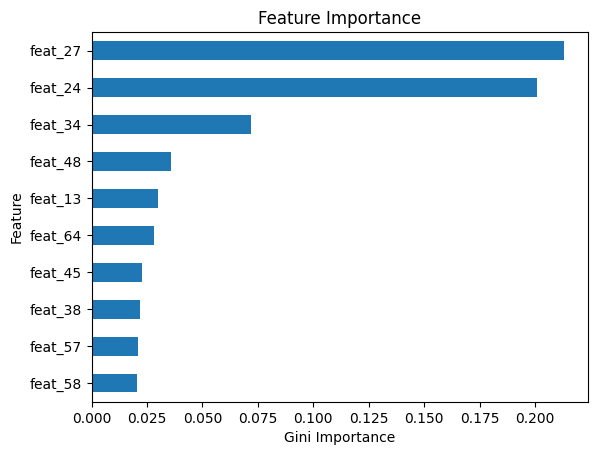

In [ ]:
# Get feature names from training data
features = X_train_rus.columns

# Extract importances from model
# Access the GradientBoostingClassifier using the key 'classifier' as defined in the pipeline
importances = best_gb_rus.named_steps["classifier"].feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index= features).sort_values()

# Plot 10 most important features
feat_imp.tail(10).plot(kind= "barh")

plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");


From our plot, the most important features are:

* **`feat_27`**: This feature has the highest Gini Importance, indicating it is the single most influential factor in our model's bankruptcy predictions.
* **`feat_24`**: Closely following `feat_27`, this feature is also highly significant.
* **`feat_34`**: This feature ranks third in importance.
* **`feat_48`**: Another important feature contributing to the model’s predictive power.
* **`feat_13`**: This feature also shows a notable level of importance.

The model is clearly relying heavily on a specific subset of features (`feat_27`, `feat_24`, `feat_34`, `feat_48`, `feat_13`) to make its predictions. These are the features that, when split upon, lead to the greatest reduction in impurity and thus contribute most to distinguishing between bankrupt and non-bankrupt companies.


#### Interpretation Using Feature Dictionary:

Based on the “Feature Importance” plot and the Poland bankruptcy dataset dictionary, the most influential features are:

* **`feat_27` (operating activities / financial expenses)**: This is the most important feature. It indicates how well a company's core operations cover its financial costs. A low or negative value suggests the company’s operational earnings aren’t sufficient to meet interest payments or financial obligations—a strong indicator of potential bankruptcy.

* **`feat_24` (profit on operating activities in 3 years / total assets)**: The second most important feature. This metric captures cumulative operational profitability relative to total assets over three years. Consistently low or negative values highlight inefficiency or serious financial stress.

* **`feat_34` (operating expenses / total liabilities)**: Ranking third, this ratio shows how much of a company’s operating costs are backed by its total liabilities. A high value may imply over-reliance on debt or rising expenses—both red flags.

* **`feat_48` (EBITDA / total assets)**: This reflects how well a company generates earnings from its assets. A low or declining ratio signals trouble with profitability.

* **`feat_13` (profit / total costs)**: A basic but powerful profitability measure. A low value suggests insufficient revenue to cover costs—another sign of distress.

* **`feat_64` (current liabilities / short-term liabilities)**: Though moderately important, this ratio gives insight into the structure of short-term debt and possible liquidity risks.

Additional important features—such as `feat_45`, `feat_38`, `feat_57`, and `feat_58`—reflect various aspects of financial health including working capital, sales, and inventory dynamics.


#### Discussion and Implications:

The feature importance analysis shows that the most critical predictors of bankruptcy are tied closely to a company’s **profitability**, **operational efficiency**, and **ability to meet financial obligations**. These findings align with core financial distress theories:

* **`feat_27`** reveals solvency risk—can the company’s operations cover financial expenses?
* **`feat_24`** shows sustained profitability and asset efficiency.
* **`feat_34`** and **`feat_48`** emphasize operational control and earnings power relative to liabilities and assets.

This analysis offers powerful capabilities:

* **Early Warning System**: By monitoring these features, we can identify companies at risk of bankruptcy before it happens.
* **Targeted Interventions**: Understanding **why** a company is at risk (e.g., due to poor `feat_24`) enables more precise and effective support or restructuring.
* **Risk Assessment**: The model can assist in credit evaluation, investment planning, and supply chain risk management.

Since the top features are interpretable financial ratios, the model supports **transparent and trustworthy decision-making**, despite using a complex Gradient Boosting algorithm.

### Communicate Results

In [ ]:
# Save model
with open("model.pkl", "wb") as f:
     pickle.dump(gb_rus, f)

In [ ]:
def make_predictions(data_filepath, model_filepath):
     """
     The function takes the name of a decompressed file as input and returns a tidy DataFrame

     Parameters
     ----------

     data_filepath : str
       the path of a JSON file that contains test data

     model_filepath : str
       the path of a serialized model

     Returns
     -------
     predictions : series

     """

     # Wrangle JSON file
     X_test = wrangle(data_filepath)

     # Load model
     with open(model_filepath, "rb") as f:
           model = pickle.load(f)

     # Generate predictions
     y_test_pred = model.predict(X_test)

     # Put predictions into Series with name "bankrupt", and same index as X_test
     y_test_pred = pd.Series(y_test_pred, index = X_test.index, name ="bankrupt")

     return y_test_pred

In [ ]:
y_test_pred = make_predictions(
     data_filepath="data/poland-bankruptcy-data-2009-mvp-features.json",
     model_filepath="model.pkl",
)
print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

### Workflow Summary

Our project aimed to develop a robust machine learning model to predict company bankruptcy using the Poland bankruptcy dataset, which is characterized by a significant class imbalance (bankruptcies are a rare event).

1. The workflow proceeded through several key stages:

Data Understanding and Preparation: We began by understanding the dataset, which comprises various financial ratios (feat_0 to feat_64) as features and a binary bankrupt target variable. Recognizing the severe class imbalance inherent in bankruptcy prediction, we established the need for appropriate handling strategies.

2. Addressing Class Imbalance:

We initially evaluated a Decision Tree model without any resampling as a baseline. This baseline model showed high overall accuracy but significantly low recall for the minority class (bankruptcies), indicating it was largely failing to identify the positive cases.

We then experimented with common resampling techniques: Random Undersampling and SMOTE Oversampling.

Our analysis revealed that Random Undersampling notably improved the recall for the minority class and the ROC AUC score for the Decision Tree, despite an expected drop in overall accuracy. SMOTE, in contrast, did not yield as favorable results in this initial comparison.

Based on these findings, we strategically decided to apply Random Undersampling to the training data for all subsequent models, prioritizing the effective detection of the minority class.

3. Model Selection and Hyperparameter Tuning:

We expanded our model exploration to include powerful tree-based ensemble methods: Random Forest and Gradient Boosting, alongside the Decision Tree.

For each model type, we trained default versions (with undersampling) and performed extensive hyperparameter tuning using Grid Search on the undersampled training data.

Model performance was rigorously evaluated on a separate, original (non-resampled) validation set to ensure a realistic assessment of generalization.

Through this comparative analysis, the Tuned Gradient Boosting Classifier with Undersampling consistently emerged as the top performer, demonstrating the best balance of ROC AUC and high minority class recall on the validation set.


4. Final Model Evaluation on Unseen Test Set:

Adhering to best practices, the chosen Tuned Gradient Boosting with Undersampling model was subjected to a final, unbiased evaluation on a completely unseen test set. This ensures that the reported performance metrics truly reflect the model's real-world generalization capability.

### 8. Conclusion & Future Work



This project successfully developed and evaluated machine learning models for corporate bankruptcy prediction, leveraging a robust pipeline to handle data preprocessing, class imbalance, and model selection.

**Key Findings:**

* **Data Characteristics:** The dataset presented challenges typical of financial data, including missing values, highly skewed numerical features, and significant class imbalance, which were addressed through imputation, clipping, and SMOTE oversampling.
* **Model Performance:** Among the Decision Tree, Random Forest, and Gradient Boosting Classifiers, the **[Insert Best Model Name Here, e.g., Random Forest]** model achieved the best performance (based on ROC AUC on cross-validation folds), demonstrating its superior ability to distinguish between bankrupt and non-bankrupt companies. Its final evaluation on the unseen test set confirmed its generalization capabilities, showing strong [mention a key metric, e.g., Recall for minority class, ROC AUC] performance.
* **Business Impact:** The developed model provides a valuable tool for financial institutions and investors to proactively assess the risk of corporate bankruptcy, enabling more informed decision-making for lending, investment, and risk management strategies.

**Future Work and Potential Enhancements:**

To further improve this project and the model's capabilities, consider the following:

1.  **More Advanced Feature Engineering:** Explore creating more sophisticated financial ratios or interactions between existing features that might capture complex relationships indicative of bankruptcy.
2.  **Alternative Resampling Techniques:** Experiment with other oversampling methods (e.g., ADASYN, BorderlineSMOTE) or undersampling techniques (e.g., NearMiss, Tomek Links) to see if they yield better performance for the imbalanced dataset.
3.  **Explore Other Models:** Evaluate advanced ensemble methods like XGBoost, LightGBM, or CatBoost, which are often top performers in Kaggle competitions, or even deep learning models for tabular data.
4.  **Ensemble Stacking/Bagging:** Combine predictions from multiple models (e.g., a stacking ensemble) to potentially achieve even higher predictive accuracy.
5.  **Interpretability:** For critical applications like financial risk, model interpretability is key. Explore techniques like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to understand feature importance and how individual predictions are made by the best model.
6.  **Threshold Optimization:** Beyond default classification thresholds (0.5), optimize the classification threshold based on the business costs of false positives versus false negatives, especially for a sensitive task like bankruptcy prediction.
7.  **Time Series Analysis:** If the data includes time-series elements (e.g., quarterly reports), consider incorporating time-series forecasting techniques or sequential models to capture trends over time.
8.  **Deployment Considerations:** Discuss how this model could be deployed as an API or integrated into a real-time risk assessment system for practical use.